# Computing the sensor location based on A Methodology for Optimal Sensor Location of a Light Pollution Network

In [1]:
from PIL import Image
import numpy as np
from sortedcontainers import SortedList
import pandas as pd
import matplotlib.pyplot as plt


import matplotlib.cbook as cbook
from matplotlib.pylab import rcParams
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib.patches as mpatches
import src.simple_LPSL as lps

Load the nighttime image of the Queretaro Metropolitan zone

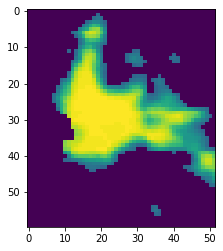

In [2]:
#Original nocturnal image without values <21
im1 = np.array(Image.open('inputs/qro_light_th'))
im1 = np.where(im1==255, 0, im1) 

plt.imshow(im1)
plt.show()

Load the vulnerability map of the region. This map was made by Jorge Paredes and Hector Solano

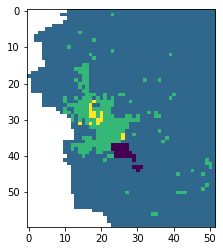

In [3]:

P = np.array(Image.open('inputs/prioridades'))

plt.imshow(P)

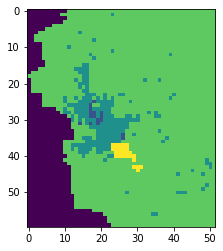

In [4]:

#This value represents the maximum number of vulnerabilties of the P image
nc = 5

#we invert the values.

# 0 max priorrity
# 4 min priority
P = np.where(np.isnan(P),nc, P)-1 
P = P.max()-P

plt.imshow(P)
plt.show()

Now we implement the ```filtro_fuerza_puntual``` on the ```im1``` image to obtain a desaturated image.

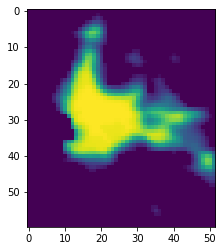

In [5]:

im1_gr = lps.filtro_fuerza_puntual(im1,h=3,e=4)

plt.imshow(im1_gr)
plt.show()


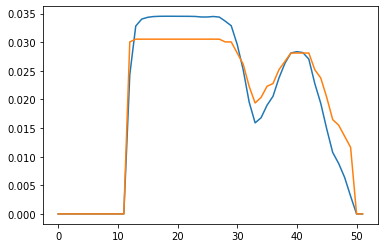

In [6]:
#The blue line is a cut of the desaturated version of the image at row 30
plt.plot(im1_gr[30,:]/np.sum(im1_gr[30,:]))
plt.plot(im1[30,:]/np.sum(im1[30,:]))

We weight the saturated and desaturated image with a weighted function f5

In [7]:
W1 = lps.f5(im1,P)
W2 = lps.f5(im1_gr,P)

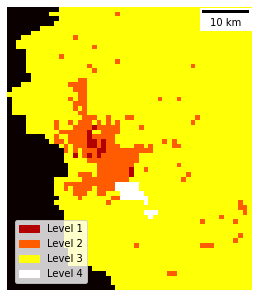

In [8]:
data = P

# get the unique values from data
# i.e. a sorted list of all values in data
values = np.unique(data.ravel())

plt.figure(figsize=(6, 5.2))
im = plt.imshow(data,cmap = plt.cm.hot)

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]

# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=int(values[i])) ) for i in range(1,5) ]

# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.33, 0.25), loc=1, borderaxespad=0.1 )
plt.axis('off')
scalebar = ScaleBar(1000) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)

plt.savefig("figures/01_importance_level_map.pdf", dpi = 150)

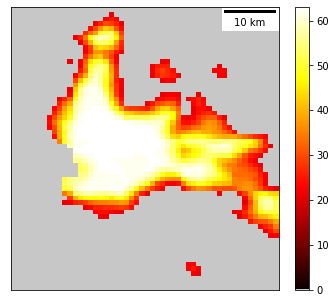

In [9]:
# we generate a map with custom colors
custom_cmap = cm.get_cmap('hot', 256)
newcolors = custom_cmap(np.linspace(0, 1, 256))
pink = np.array([200/256, 200/256, 200/256, 1])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)
lps.plot_examples(im1,[newcmp],"figures/02_original_nighttime.pdf")


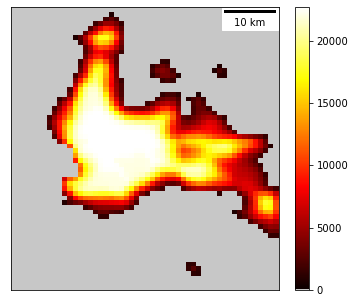

In [10]:
# we show the desaturated image
lps.plot_examples(im1_gr,[newcmp],"figures/03_gravitational_nighttime_map.pdf")


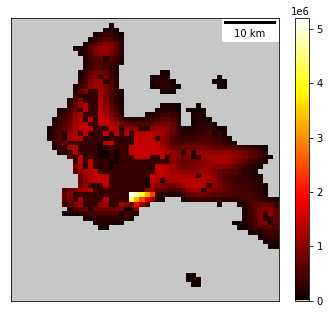

In [11]:
#This is the most important map, that shows the rank of cells. Cells with higher value, needs a light sensor near than dar cells.
lps.plot_examples(W2,[newcmp],"figures/04_priority_levels.pdf")



We compute all the local maxima

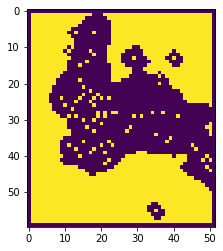

In [12]:
B = np.zeros(im1_gr.shape)
for i in range(1,im1_gr.shape[0]-1):
    for j in range(1,im1_gr.shape[1]-1):

        B[i][j] = lps.getN(W2,i,j)
        
positionsB = B*(im1>0)

#all the local maxima
plt.imshow(B)
plt.show()

Locations over the priority level map

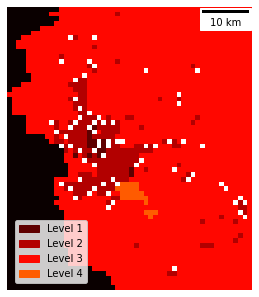

In [13]:
locationsP = np.zeros(P.shape)
for i in range(0,P.shape[0]):
    for j in range(0,P.shape[1]):
        locationsP[i][j] = 8 if positionsB[i][j]==1 else P[i,j]

data = locationsP


# get the unique values from data
# i.e. a sorted list of all values in data
values = np.unique(data.ravel())

plt.figure(figsize=(6, 5.2))
im = plt.imshow(data,cmap = plt.cm.hot)

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=int(values[i])) ) for i in range(1,5) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.33, 0.25), loc=1, borderaxespad=0.1 )
plt.axis('off')
scalebar = ScaleBar(1000) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)

plt.savefig("figures/05_positions_and_importance.pdf", dpi = 150)


This final map show the prioriy as the result of rank ordering the local maxima according to the weights in descent order. 
Whitest point means high priority location to locate a sensor. This match with the highest value in the desaturated map in a region with high vulnerability.


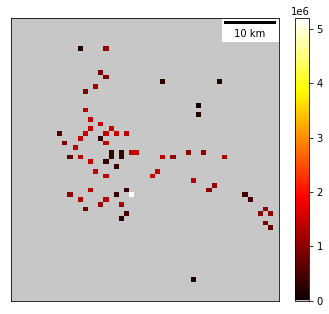

In [14]:
custom_cmap = cm.get_cmap('hot', 256)
newcolors = custom_cmap(np.linspace(0, 1, 256))
pink = np.array([200/256, 200/256, 200/256, 1])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)
lps.plot_examples(W2*positionsB,[newcmp],"figures/06_positions_with_priority.pdf")

**References**

* https://grass.osgeo.org/grass76/manuals/r.neighbors.html
* https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
